In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import torch
from torch import nn, optim, utils
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import os
import time
from tqdm import tqdm
import copy

In [2]:
data_dir = '/home/samael/github/image_generation/'
worker = 8
batch_size = 8
image_size = 256
num_epochs = 10
lr = 1e-3
momentum = 0.9
ngpu = 2

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: vdatasets.ImageFolder(os.path.join(
    data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=worker) for x in ['train', 'val']}
print('Initialized!')

Initializing Datasets and Dataloaders...
Initialized!


In [4]:
device = torch.device('cuda:0')

In [5]:
def norm_image(image):
    min_val = torch.min(image)
    max_val = torch.max(image)
    return (image - min_val) / (max_val - min_val)

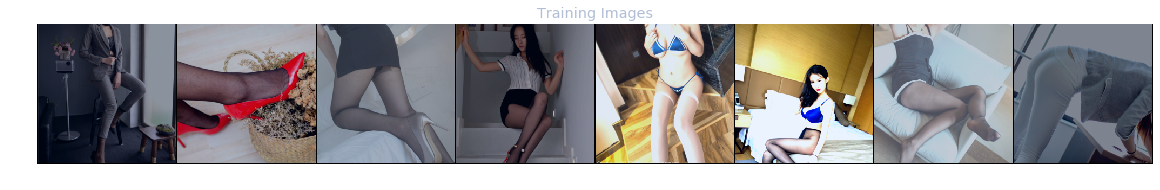

In [6]:
real_batch = next(iter(dataloaders_dict['train']))
val_batch = next(iter(dataloaders_dict['val']))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [8]:
def vgg11_bn():
    model = VGG(make_layers(cfg['A'], batch_norm=True), num_classes=7)
    return model

In [9]:
net = vgg11_bn()
net = net.to(device)
if ngpu > 1:
    net = nn.DataParallel(net, list(range(ngpu)))

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        time_elapsed = time.time() - since
        hour = time_elapsed // 3600
        minute = (time_elapsed - hour * 3600) // 60
        second = (time_elapsed - hour * 3600) % 60
        print("Training elapsed {:.0f}h {:.0f}m {:.0f}s".format(hour, minute, second))
        print()
    
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [11]:
optimizer_ft = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [12]:
model_ft, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model(net, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 2.0364 Acc: 0.2377
val Loss: 2.1742 Acc: 0.2748
Training elapsed 0h 3m 17s

Epoch 2/10
----------
train Loss: 1.7397 Acc: 0.3102
val Loss: 1.9188 Acc: 0.3079
Training elapsed 0h 6m 33s

Epoch 3/10
----------
train Loss: 1.6769 Acc: 0.3406
val Loss: 1.7980 Acc: 0.3461
Training elapsed 0h 9m 48s

Epoch 4/10
----------
train Loss: 1.5987 Acc: 0.3847
val Loss: 2.1653 Acc: 0.3537
Training elapsed 0h 13m 3s

Epoch 5/10
----------
train Loss: 1.5206 Acc: 0.4214
val Loss: 2.1079 Acc: 0.3486
Training elapsed 0h 16m 18s

Epoch 6/10
----------
train Loss: 1.4914 Acc: 0.4388
val Loss: 2.1561 Acc: 0.3257
Training elapsed 0h 19m 34s

Epoch 7/10
----------
train Loss: 1.4302 Acc: 0.4593
val Loss: 2.2160 Acc: 0.3384
Training elapsed 0h 22m 49s

Epoch 8/10
----------
train Loss: 1.3861 Acc: 0.4907
val Loss: 2.4403 Acc: 0.3410
Training elapsed 0h 26m 5s

Epoch 9/10
----------
train Loss: 1.3188 Acc: 0.5110
val Loss: 2.0842 Acc: 0.3435
Training elapsed 0h 29m 20s

Epoch 

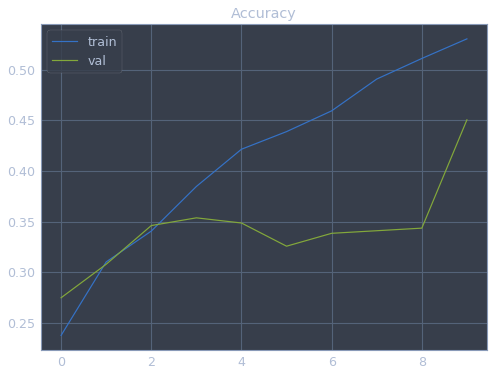

In [13]:
plt.figure(figsize=(8, 6))
plt.title('Accuracy')
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.legend(['train', 'val'])
plt.show()

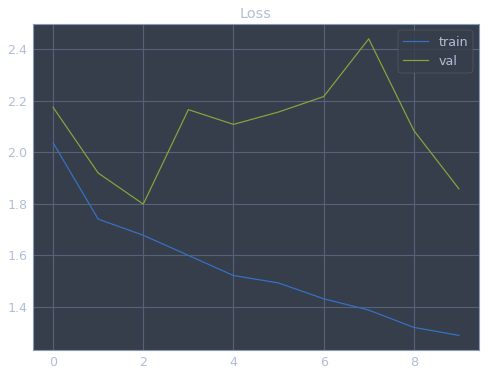

In [14]:
plt.figure(figsize=(8, 6))
plt.title('Loss')
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.legend(['train', 'val'])
plt.show()

In [15]:
classes = ['black_tights', 'fishnet', 'flesh_colored', 'other_colors', 'others', 'pants', 'white_tights']

In [16]:
train_prob, train_pred = torch.max(F.softmax(net(real_batch[0][:9].to(device)), dim=1), 1)
val_prob, val_pred = torch.max(F.softmax(net(val_batch[0][:9].to(device)), dim=1), 1)

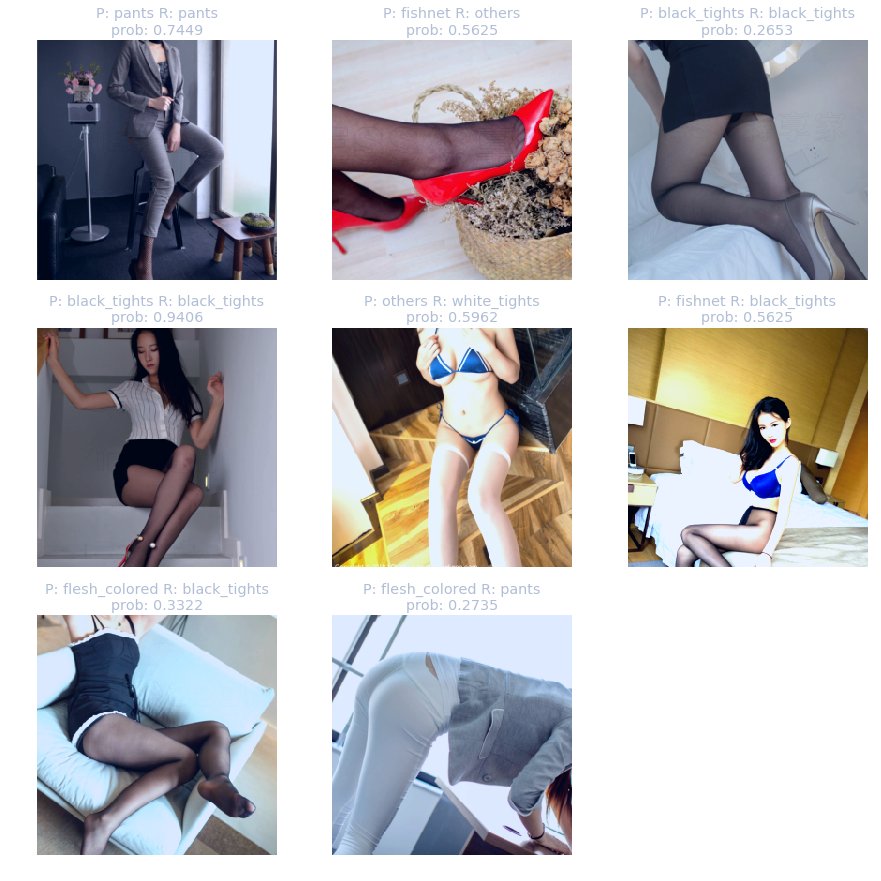

In [18]:
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: '+classes[train_pred[i]] + " R: " + classes[real_batch[1][i]] + '\n' + 'prob: %.4f' %(train_prob[i]))
    plt.imshow(norm_image(real_batch[0][i]).permute(1, 2, 0))
plt.show()

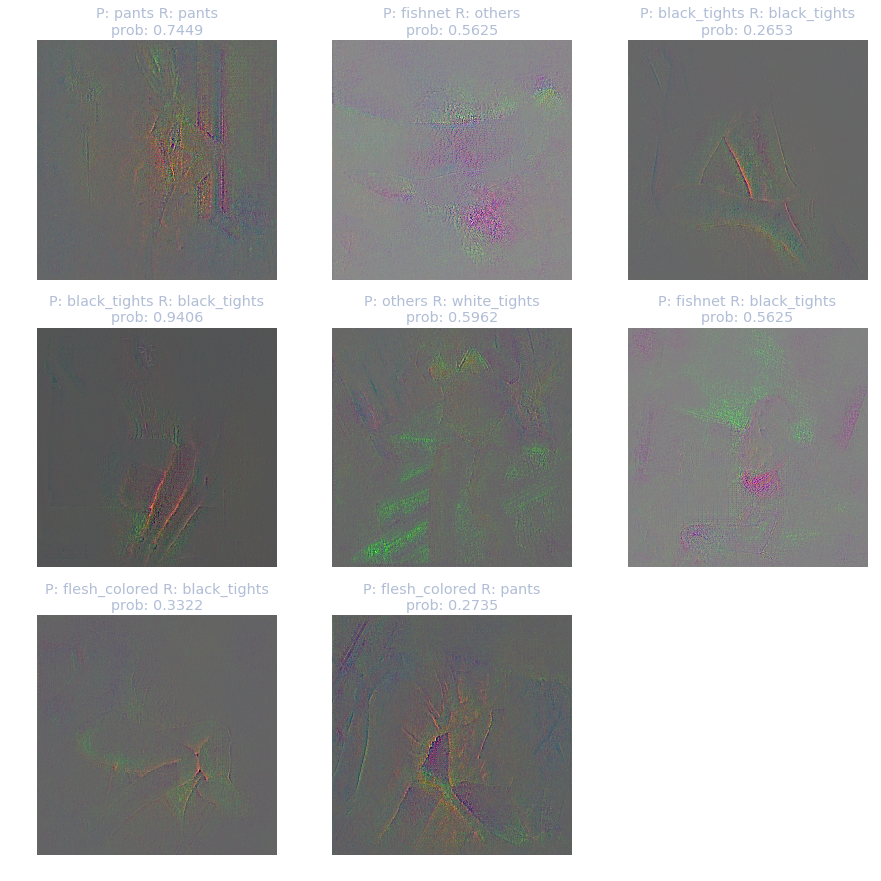

In [19]:
data = real_batch[0][:9]
data.requires_grad = True
out = net(data)
loss = criterion(out, real_batch[1][:9].to(device))
loss.backward()
saliency = data.grad.data

plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[train_pred[i]] + " R: " + classes[real_batch[1][i]] + '\n' + 'prob: %.4f' %(train_prob[i]))
    plt.imshow(norm_image(saliency[i]).permute(1, 2, 0))
plt.show()

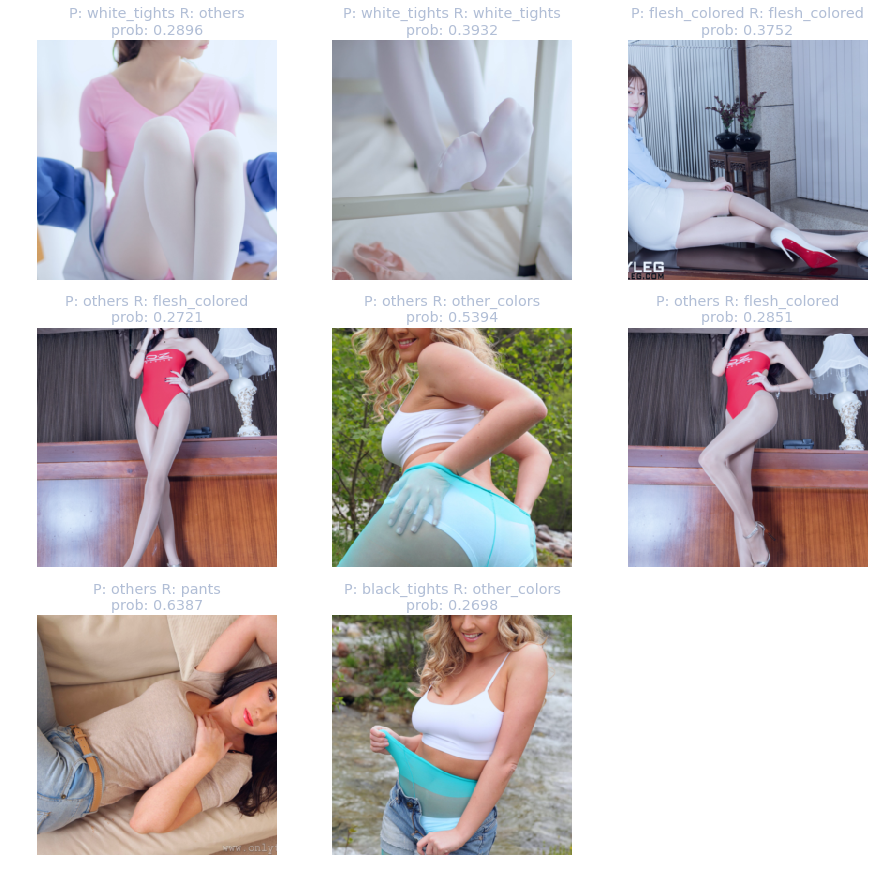

In [20]:
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[val_pred[i]] + " R: " + classes[val_batch[1][i]] + '\n' + 'prob: %.4f' %(val_prob[i]))
    plt.imshow(norm_image(val_batch[0][i]).permute(1, 2, 0))
plt.show()

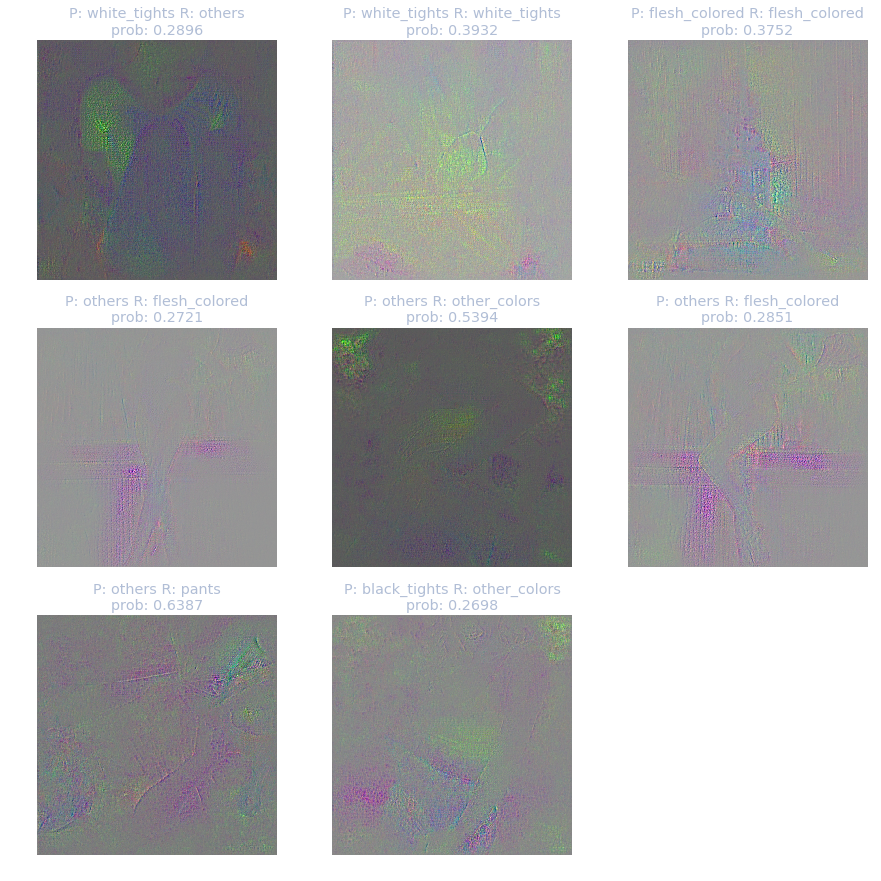

In [21]:
data = val_batch[0][:9]
data.requires_grad = True
out = net(data)
loss = criterion(out, val_batch[1][:9].to(device))
loss.backward()
saliency = data.grad.data

plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.axis("off")
    plt.title('P: ' + classes[val_pred[i]] + " R: " + classes[val_batch[1][i]] + '\n' + 'prob: %.4f' %(val_prob[i]))
    plt.imshow(norm_image(saliency[i]).permute(1, 2, 0))
plt.show()